In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [4]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
from POSEIDON.utility import read_high_res_data_deprecate
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import h5py
import matplotlib.pyplot as plt

In [5]:
# data_dir = "./data/WASP-76b-MAROON/"
# nights = ["night_1", "night_2", "night_3", "night_4", "night_5", "night_6"]
# names = [
#     "night_1_blue",
#     "night_1_red",
#     "night_2_blue",
#     "night_2_red",
#     "night_3_blue",
#     "night_3_red",
# ]
data_dir = "./data/WASP-121b/"
names = ["blue", "redl", "redu"]
# data = h5py.File("../hdf5_experiments/data/WASP-121b.h5", "r")
# os.makedirs("./data/WASP-121b/", exist_ok=True)
# for key in data.keys():
#     os.makedirs(f"./data/WASP-121b/{key}", exist_ok=True)
#     with h5py.File(f"./data/WASP-121b/{key}/data_raw.hdf5", "a") as f:
#         f.create_dataset("wl_grid", data=data[key]["wl_grid"])
#         f.create_dataset("phi", data=data[key]["phi"])
#         f.create_dataset("flux", data=data[key]["flux"])
#         f.create_dataset("transit_weight", data=data[key]["transit_weight"])

#     with h5py.File(f"./data/WASP-121b/{key}/data_processed.hdf5", "a") as f:
#         f.create_dataset("uncertainties_processed", data=data[key]["uncertainties"])
#         f.create_dataset("Bs", data=data[key]["Bs"])
#         f.create_dataset("residuals", data=data[key]["residuals"])
#         f.create_dataset("flux_blaze_corrected", data=data[key]["flux_blaze_corrected"])
#         f.create_dataset("uncertainties", data=data[key]["uncertainties"])
#         f.create_dataset("transit_weight", data=data[key]["transit_weight"])
#         f.create_dataset("wl_grid", data=data[key]["wl_grid"])
#         f.create_dataset("phi", data=data[key]["phi"])

In [ ]:
# for i in range(len(nights)):
#     data = read_high_res_data_deprecate(
#         data_dir + nights[i], method="sysrem", spectrum_type="transmission"
#     )
#     flux = data["data_raw"]
#     wl_grid = data["wl_grid"][:]
#     phi = data["phi"]
#     tranist_weight = data["transit_weight"]
#     flux = remove_outliers(wl_grid, flux)
#     add_high_res_data(
#         data_dir,
#         names[i],
#         flux,
#         wl_grid,
#         phi,
#         tranist_weight,
#         overwrite=False,
#     )

In [ ]:
# from POSEIDON.utility import read_high_res_data_deprecate

# for i in range(len(nights)):
#     data = read_high_res_data_deprecate(
#         data_dir + nights[i], method="sysrem", spectrum_type="transmission"
#     )
#     flux = data["data_raw"]
#     wl_grid = data["wl_grid"][:]
#     phi = data["phi"]
#     tranist_weight = data["transit_weight"]
#     flux = remove_outliers(wl_grid, flux)
#     add_high_res_data(
#         data_dir,
#         names[i],
#         flux,
#         wl_grid,
#         phi,
#         tranist_weight,
#         overwrite=False,
#     )

In [ ]:
# for name in names[:]:
#     prepare_high_res_data(
#         data_dir,
#         name,
#         "transmission",
#         "sysrem_2022",
#         stack_order=True,
#         overwrite=False,
#         Print=True,
#         niter=15,
#         n_PC=5,
#     )

In [6]:
from POSEIDON.core import define_model, wl_grid_constant_R

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 1.753 * R_J  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R, make_atmosphere

# ***** Define model *****#

model_name = "Fe"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# param_species = ["Fe", "Cr", "Mg", "V"]
param_species = ["Fe"]

high_res = "sysrem"
high_res_params = ["K_p", "V_sys", "W_conv", "log_a"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    high_res_params=high_res_params,
)

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.87  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2900  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3100  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [7]:
model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    high_res_params=high_res_params,
    # cloud_model="MacMad17",
    # cloud_type="deck",
)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# log_species = [-5, -7, -4, -8]
log_species = [-5]
T = 3000

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])  # a1, a2, log_P1, log_P2, log_P3, T_deep
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet,
    model,
    P,
    P_ref,
    R_p_ref,
    PT_params,
    log_X_params,
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

In [22]:
def cross_correlate(
    Kp_range, Vsys_range, RV_range, wl, planet_spectrum, data, Print=True
):
    if Print:
        time0 = time.time()
    uncertainties = data["uncertainties_processed"]
    residuals = data["residuals"]
    phi = data["phi"]
    wl_grid = data["wl_grid"]
    transit_weight = data["transit_weight"]
    max_transit_depth = np.max(1 - transit_weight)

    norder, nphi, npix = residuals.shape
    CCF_Kp_Vsys = np.zeros((len(Kp_range), len(Vsys_range)))

    nRV = len(RV_range)
    CCF_phase_RV = np.zeros((nphi, nRV))
    models_shifted = np.zeros((nRV, norder, npix))
    for RV_i, RV in enumerate(RV_range):
        # Looping through each order and computing total log-L by summing logLs for each obvservation/order
        for order_i in range(norder):
            wl_slice = wl_grid[order_i]  # Cropped wavelengths
            delta_lambda = RV * 1e3 / constants.c
            wl_shifted = wl * (1.0 + delta_lambda)
            F_p = np.interp(wl_slice, wl_shifted, planet_spectrum)
            models_shifted[RV_i, order_i] = F_p  # choose not to filter

    # negative of transmission spectrum gives absorption. Adding or multiplying constant does not change the CCF
    m = -models_shifted
    # already minus mean in prepare_data

    for phi_i in range(nphi):
        for RV_i in range(nRV):
            f = residuals[:, phi_i, :]
            CCF = np.sum(f[:, :] * m[RV_i, :, :] / uncertainties[:, phi_i, :] ** 2)
            CCF_phase_RV[phi_i, RV_i] += CCF

    CCF_phase_RV = (1 - transit_weight[:, None]) * CCF_phase_RV

    for Kp_i, Kp in enumerate(Kp_range):
        for phi_i in range(nphi):
            RV = Kp * np.sin(2 * np.pi * phi[phi_i]) + Vsys_range
            CCF_Kp_Vsys[Kp_i] += np.interp(RV, RV_range, CCF_phase_RV[phi_i])
    if Print:
        time1 = time.time()
        print("Cross correlation took {} seconds".format(time1 - time0))
    return CCF_Kp_Vsys, CCF_phase_RV

In [23]:
from PyAstronomy import pyasl
import POSEIDON

data = POSEIDON.high_res.read_high_res_data(data_dir, names=names)
# spectrum = np.load("./data/WASP-76b-MAROON/" + "models/Fe.npy")
# model_wave = np.load("./data/WASP-76b-MAROON/" + "models/wave.npy")
model_wave = wl
# model_wave = pyasl.vactoair2(model_wave * 1e4) / 1e4

In [24]:
# from scipy.ndimage import gaussian_filter1d, minimum_filter1d

# plt.plot(
#     wl,
#     spectrum,
#     label="POSEIDON",
# )

# # spectrum = np.load(data_dir + "models/VO.npy")
# model_wave = np.load(data_dir + "models/wave.npy")
# plt.plot(model_wave, np.load(data_dir + "models/VO.npy") / 1e6, label="Pelletier")
# plt.legend()
# plt.xlim(0.5, 0.9)

In [25]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-400, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        model_wave,
        gaussian_filter1d(
            spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 1000), 400), 5
        ),
        # spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 29.264684677124023 seconds
Cross correlation took 34.955357789993286 seconds
Cross correlation took 25.436426401138306 seconds


In [19]:
# CCF_Kp_Vsys_all[3]=0

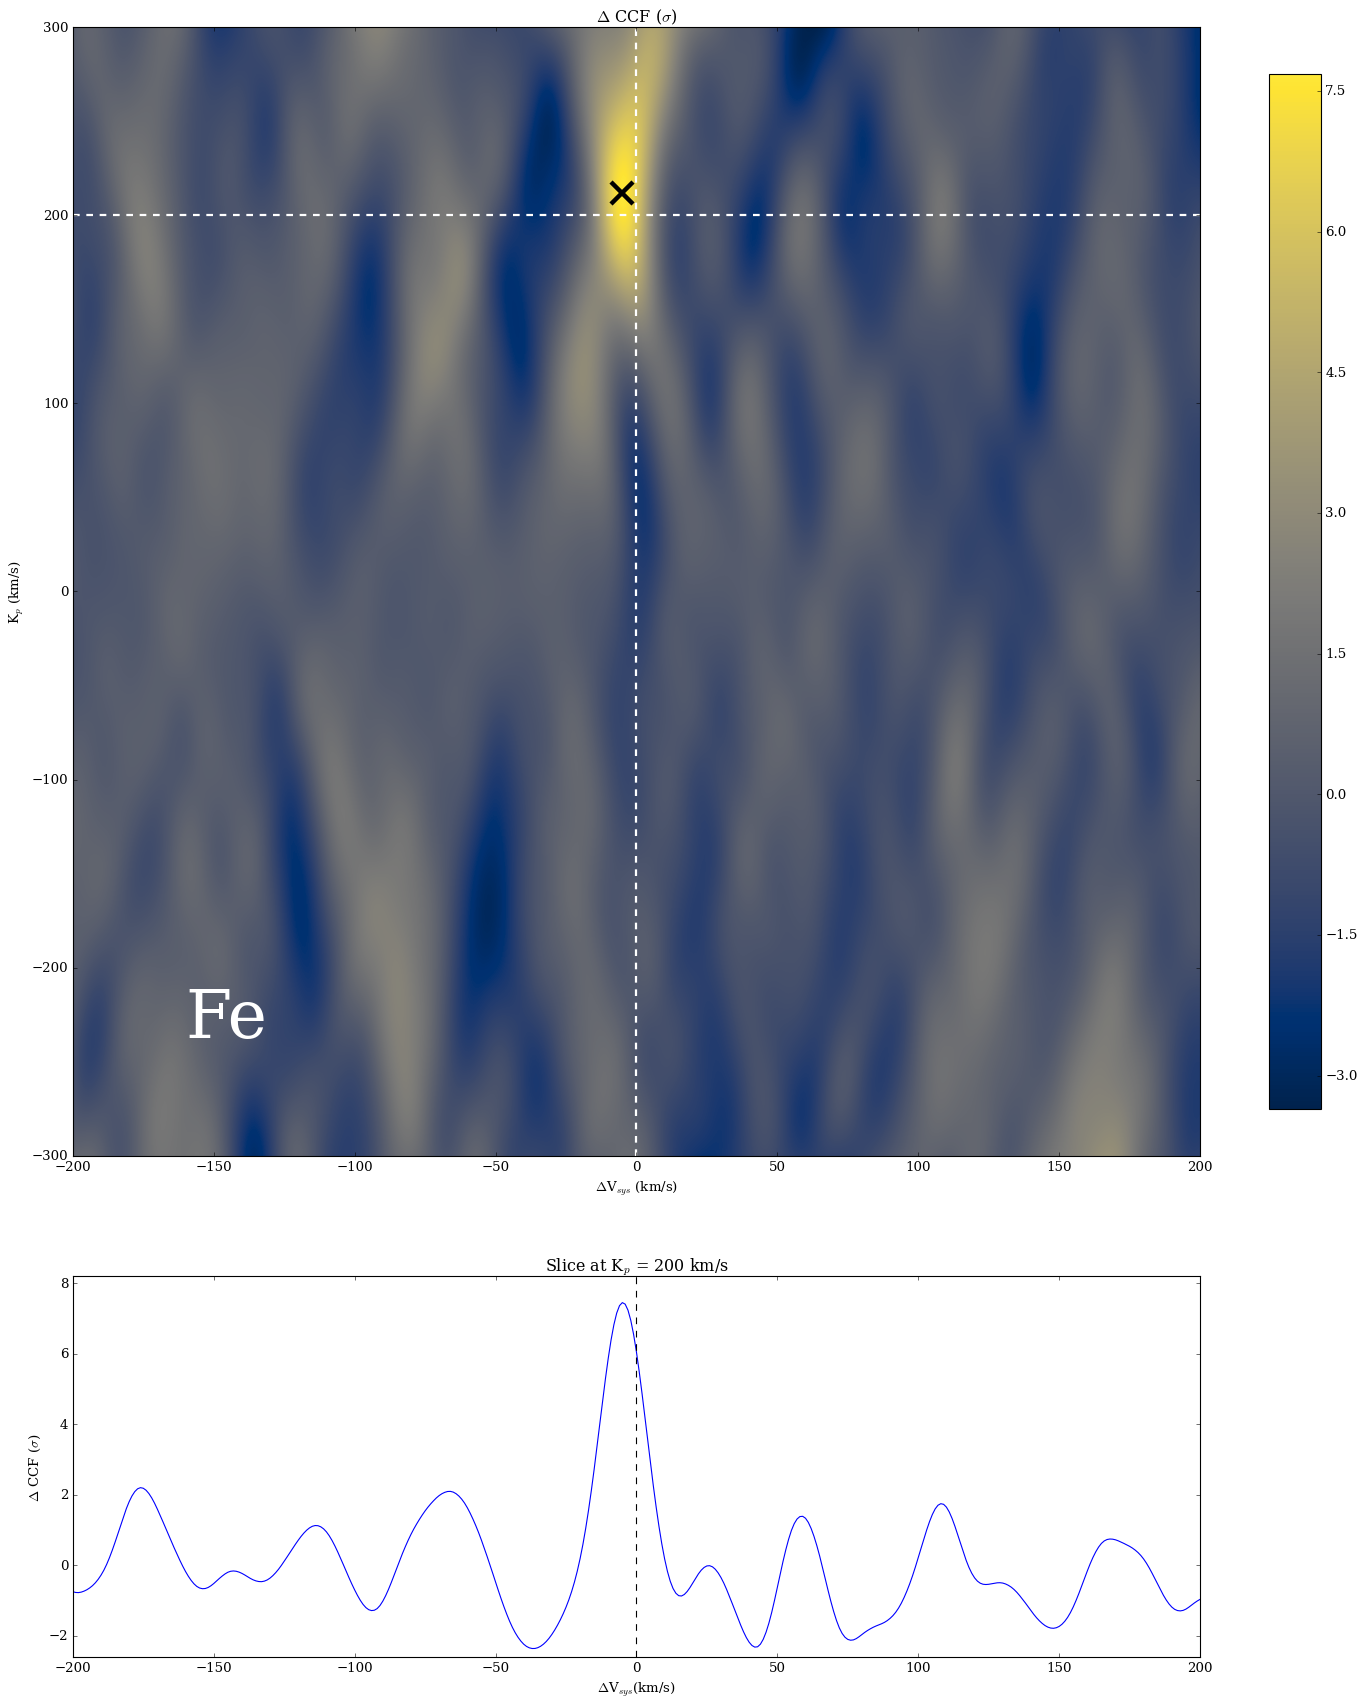

In [20]:
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "Fe",
    200,
    Vsys=0,
    RM_mask_size=20,
    plot_label=True,
)